In [ ]:
pip install scikit-plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import json
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
import keras 
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, Conv1D, Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization, MaxPool2D, MaxPooling1D, Activation, MaxPooling2D, LSTM
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import scipy
from sklearn.model_selection import train_test_split


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/audio_speech_actors_01-24/"

Modality = []
Vocal_channel = []
Emotion  = []
Emotional_intensity = []
Statement = []
Repetition = []
Actor = []
Paths = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATA_PATH)):
  if dirpath is not DATA_PATH:
    for f in filenames:
      if '(1)' not in f: #eliminate coincidences
        file_path = os.path.join(dirpath, f)
        Paths.append(file_path)
        Modality.append(f.split('.')[0].split('-')[0])
        Vocal_channel.append(f.split('.')[0].split('-')[1])
        Emotion.append(f.split('.')[0].split('-')[2])
        Emotional_intensity.append(f.split('.')[0].split('-')[3])
        Statement.append(f.split('.')[0].split('-')[4])
        Repetition.append(f.split('.')[0].split('-')[5])
        Actor.append(int(f.split('.')[0].split('-')[6]))

Ravdess_DF = pd.DataFrame()
Ravdess_DF['Paths'] = Paths
Ravdess_DF['Modality'] = Modality
Ravdess_DF['Vocal_channel'] = Vocal_channel
Ravdess_DF['Emotion'] = Emotion
Ravdess_DF['Emotional_intensity'] = Emotional_intensity
Ravdess_DF['Statement'] = Statement
Ravdess_DF['Repetition'] = Repetition
Ravdess_DF['Actor'] = Actor

In [ ]:
Ravdess_DF.head()

,Paths,Modality,Vocal_channel,Emotion,Emotional_intensity,Statement,Repetition,Actor
0,/content/drive/MyDrive/Colab Notebooks/speech/...,03,01,02,01,01,02,1
1,/content/drive/MyDrive/Colab Notebooks/speech/...,03,01,03,02,02,02,1
2,/content/drive/MyDrive/Colab Notebooks/speech/...,03,01,04,02,02,01,1
3,/content/drive/MyDrive/Colab Notebooks/speech/...,03,01,05,02,02,01,1
4,/content/drive/MyDrive/Colab Notebooks/speech/...,03,01,02,01,02,02,1


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/AudioWAV/"

ActorID = []
Statement = []
Emotion  = []
Emotional_level = []
Paths = []

links = os.listdir(DATA_PATH)
for f in links:
  file_path = os.path.join(DATA_PATH, f)
  Paths.append(file_path)
  ActorID.append(f.split('.')[0].split('_')[0])
  Statement.append(f.split('.')[0].split('_')[1])
  Emotion.append(f.split('.')[0].split('_')[2])
  Emotional_level.append(f.split('.')[0].split('_')[3])

CREMA_D_df = pd.DataFrame()
CREMA_D_df['ActorID'] = ActorID
CREMA_D_df['Statement'] = Statement
CREMA_D_df['Emotion'] = Emotion
CREMA_D_df['Emotional_level'] = Emotional_level
CREMA_D_df['Paths'] = Paths

In [ ]:
CREMA_D_df.head()

,ActorID,Statement,Emotion,Emotional_level,Paths
0,1079,TIE,HAP,XX,/content/drive/MyDrive/Colab Notebooks/speech/...
1,1080,DFA,HAP,XX,/content/drive/MyDrive/Colab Notebooks/speech/...
2,1079,TIE,FEA,XX,/content/drive/MyDrive/Colab Notebooks/speech/...
3,1079,WSI,FEA,XX,/content/drive/MyDrive/Colab Notebooks/speech/...
4,1079,TIE,DIS,XX,/content/drive/MyDrive/Colab Notebooks/speech/...


# mfcc_13 + basic model

In [ ]:
features = []
labels = []

for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T,axis=0).tolist()
    features.append(mfcc)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T,axis=0).tolist()
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(13, input_shape=(13, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 19,002
Trainable params: 19,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
75/75 [==============================] - 1s 4ms/step - loss: 3.8728 - accuracy: 0.2646 - val_loss: 1.4194 - val_accuracy: 0.3245
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4099 - accuracy: 0.3368 - val_loss: 1.3773 - val_accuracy: 0.3605
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3140 - accuracy: 0.3718 - val_loss: 1.2070 - val_accuracy: 0.4042
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2693 - accuracy: 0.3920 - val_loss: 1.2067 - val_accuracy: 0.4023
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2806 - accuracy: 0.3861 - val_loss: 1.4198 - val_accuracy: 0.3378
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3123 - accuracy: 0.3893 - val_loss: 1.3902 - val_accuracy: 0.4118
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2966 - accuracy: 0.3820 - val_loss: 1.2563 - val_accuracy: 0.3776
Epoch 8/200
7

In [ ]:
model.save('./basic_mfcc13_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.65      0.76      0.70       151
        fear       0.50      0.23      0.31       136
       happy       0.46      0.43      0.44       140
         sad       0.61      0.82      0.70       159

    accuracy                           0.58       586
   macro avg       0.55      0.56      0.54       586
weighted avg       0.56      0.58      0.55       586



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

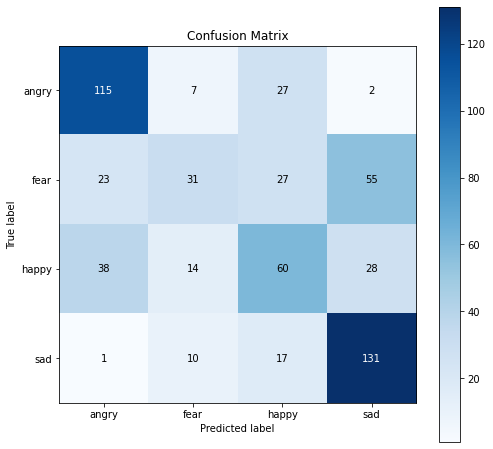

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + basic model

In [ ]:
features = []
labels = []

for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T,axis=0).tolist()
    features.append(mfcc)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T,axis=0).tolist()
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(26, input_shape=(26, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 26)                702       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3456      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 21,186
Trainable params: 21,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 3.4947 - accuracy: 0.3346 - val_loss: 1.7452 - val_accuracy: 0.3643
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 1.5768 - accuracy: 0.3753 - val_loss: 1.2310 - val_accuracy: 0.4118
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2860 - accuracy: 0.4254 - val_loss: 1.8742 - val_accuracy: 0.3605
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4973 - accuracy: 0.4169 - val_loss: 2.3115 - val_accuracy: 0.2486
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 1.5306 - accuracy: 0.3941 - val_loss: 2.7222 - val_accuracy: 0.2884
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 1.8006 - accuracy: 0.4068 - val_loss: 1.2695 - val_accuracy: 0.4288
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2920 - accuracy: 0.4325 - val_loss: 1.6709 - val_accuracy: 0.2581
Epoch 8/200
7

In [ ]:
model.save('./basic_mfcc26_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.71      0.73      0.72       151
        fear       0.42      0.33      0.37       136
       happy       0.50      0.54      0.52       140
         sad       0.63      0.69      0.66       159

    accuracy                           0.58       586
   macro avg       0.57      0.57      0.57       586
weighted avg       0.57      0.58      0.57       586



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

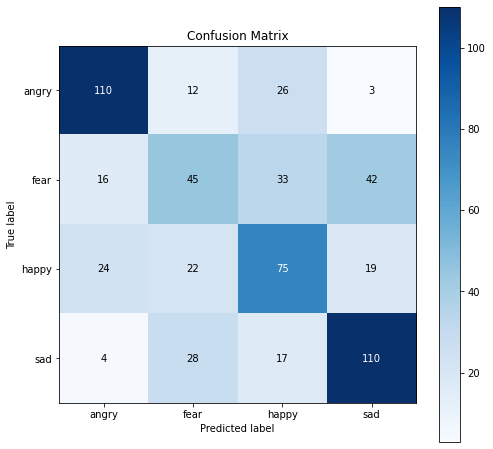

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + basic model

In [ ]:
features = []
labels = []

for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0).tolist()
    features.append(mfcc)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0).tolist()
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(39, input_shape=(39, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               5120      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 23,708
Trainable params: 23,708
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 11.3197 - accuracy: 0.2966 - val_loss: 1.9004 - val_accuracy: 0.3966
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 1.6547 - accuracy: 0.3615 - val_loss: 1.7576 - val_accuracy: 0.2846
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4076 - accuracy: 0.3915 - val_loss: 1.8049 - val_accuracy: 0.3283
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4313 - accuracy: 0.3883 - val_loss: 1.5327 - val_accuracy: 0.3662
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3498 - accuracy: 0.4216 - val_loss: 1.2664 - val_accuracy: 0.4383
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3054 - accuracy: 0.4290 - val_loss: 1.1931 - val_accuracy: 0.4649
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2382 - accuracy: 0.4503 - val_loss: 1.5600 - val_accuracy: 0.3757
Epoch 8/200


In [ ]:
model.save('./basic_mfcc39_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.67      0.72      0.69       151
        fear       0.36      0.43      0.39       136
       happy       0.47      0.34      0.40       140
         sad       0.62      0.62      0.62       159

    accuracy                           0.53       586
   macro avg       0.53      0.53      0.52       586
weighted avg       0.54      0.53      0.53       586



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

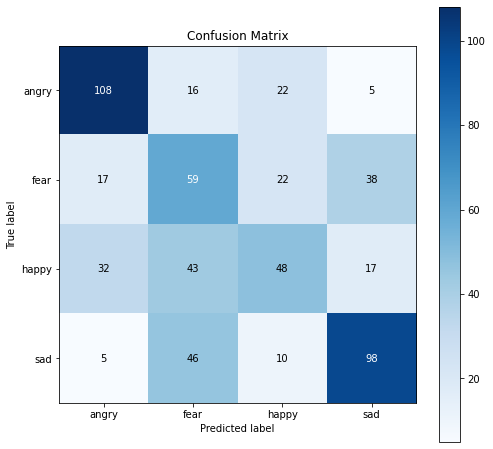

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_13 + conv1D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)
    
for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4739, 1690, 1), (586, 1690, 1), (4739, 4), (586, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1690, 64)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 1690, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 1690, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 422, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 422, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 422, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 422, 64)          

In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 8s 14ms/step - loss: 1.3219 - categorical_accuracy: 0.4430 - val_loss: 1.5611 - val_categorical_accuracy: 0.3416
Epoch 2/200
297/297 [==============================] - 2s 8ms/step - loss: 1.1022 - categorical_accuracy: 0.5087 - val_loss: 1.1600 - val_categorical_accuracy: 0.4611
Epoch 3/200
297/297 [==============================] - 2s 8ms/step - loss: 1.1180 - categorical_accuracy: 0.4985 - val_loss: 1.1286 - val_categorical_accuracy: 0.5123
Epoch 4/200
297/297 [==============================] - 2s 8ms/step - loss: 1.1231 - categorical_accuracy: 0.4992 - val_loss: 1.0743 - val_categorical_accuracy: 0.5180
Epoch 5/200
297/297 [==============================] - 2s 8ms/step - loss: 1.0611 - categorical_accuracy: 0.5112 - val_loss: 1.0617 - val_categorical_accuracy: 0.5199
Epoch 6/200
297/297 [==============================] - 2s 7ms/step - loss: 1.0698 - categorical_accuracy: 0.5123 - val_loss: 1.0867 - val_categorical_accuracy: 0.53

In [ ]:
model.save('./conv1D_mfcc13_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.81      0.70      0.75       151
        fear       0.41      0.33      0.37       136
       happy       0.51      0.39      0.44       140
         sad       0.58      0.87      0.70       159

    accuracy                           0.59       586
   macro avg       0.58      0.57      0.57       586
weighted avg       0.58      0.59      0.57       586



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

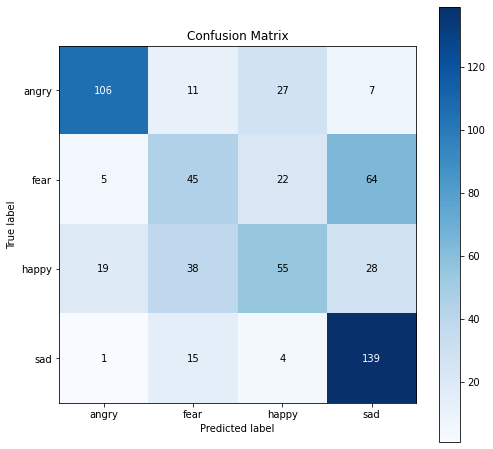

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + conv1D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4739, 3380, 1), (586, 3380, 1), (4739, 4), (586, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3380, 64)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 3380, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 3380, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 845, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 845, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 845, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 845, 64)          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 55s 16ms/step - loss: 1.3511 - categorical_accuracy: 0.4213 - val_loss: 1.9398 - val_categorical_accuracy: 0.2694
Epoch 2/200
297/297 [==============================] - 3s 11ms/step - loss: 1.1504 - categorical_accuracy: 0.4752 - val_loss: 1.6491 - val_categorical_accuracy: 0.3567
Epoch 3/200
297/297 [==============================] - 3s 12ms/step - loss: 1.1243 - categorical_accuracy: 0.4977 - val_loss: 1.1268 - val_categorical_accuracy: 0.4497
Epoch 4/200
297/297 [==============================] - 3s 12ms/step - loss: 1.1113 - categorical_accuracy: 0.4837 - val_loss: 1.2351 - val_categorical_accuracy: 0.4421
Epoch 5/200
297/297 [==============================] - 3s 12ms/step - loss: 1.1115 - categorical_accuracy: 0.4904 - val_loss: 1.1691 - val_categorical_accuracy: 0.4649
Epoch 6/200
297/297 [==============================] - 3s 11ms/step - loss: 1.1297 - categorical_accuracy: 0.4942 - val_loss: 1.0925 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc26_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.92      0.35      0.51       129
        fear       0.46      0.58      0.51       174
       happy       0.44      0.41      0.42       127
         sad       0.60      0.76      0.67       156

    accuracy                           0.54       586
   macro avg       0.60      0.53      0.53       586
weighted avg       0.59      0.54      0.53       586



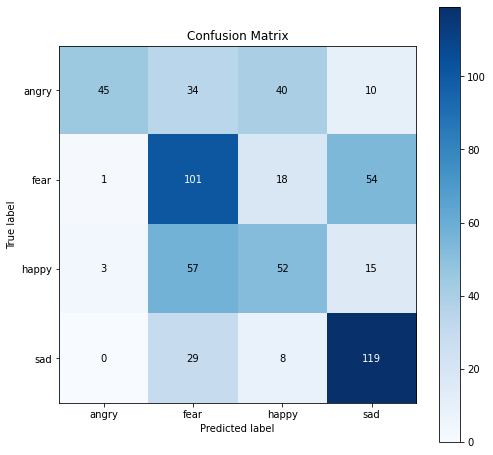

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + conv1D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = mfcc.reshape(-1,1)
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4739, 5070, 1), (586, 5070, 1), (4739, 4), (586, 4))

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5070, 64)          256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 5070, 64)          256       
_________________________________________________________________
activation_4 (Activation)    (None, 5070, 64)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1267, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1267, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1267, 64)          12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1267, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 10s 20ms/step - loss: 1.3470 - categorical_accuracy: 0.4169 - val_loss: 1.6187 - val_categorical_accuracy: 0.2827
Epoch 2/200
297/297 [==============================] - 5s 15ms/step - loss: 1.1580 - categorical_accuracy: 0.4783 - val_loss: 1.7136 - val_categorical_accuracy: 0.2922
Epoch 3/200
297/297 [==============================] - 5s 15ms/step - loss: 1.0928 - categorical_accuracy: 0.5095 - val_loss: 1.2473 - val_categorical_accuracy: 0.4440
Epoch 4/200
297/297 [==============================] - 5s 15ms/step - loss: 1.0966 - categorical_accuracy: 0.4950 - val_loss: 1.2458 - val_categorical_accuracy: 0.4478
Epoch 5/200
297/297 [==============================] - 5s 15ms/step - loss: 1.1063 - categorical_accuracy: 0.5051 - val_loss: 1.1254 - val_categorical_accuracy: 0.4858
Epoch 6/200
297/297 [==============================] - 5s 16ms/step - loss: 1.1105 - categorical_accuracy: 0.4994 - val_loss: 1.2475 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv1D_mfcc39_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.54      0.80      0.64       129
        fear       0.50      0.01      0.02       174
       happy       0.36      0.64      0.46       127
         sad       0.67      0.72      0.69       156

    accuracy                           0.51       586
   macro avg       0.52      0.54      0.45       586
weighted avg       0.52      0.51      0.43       586



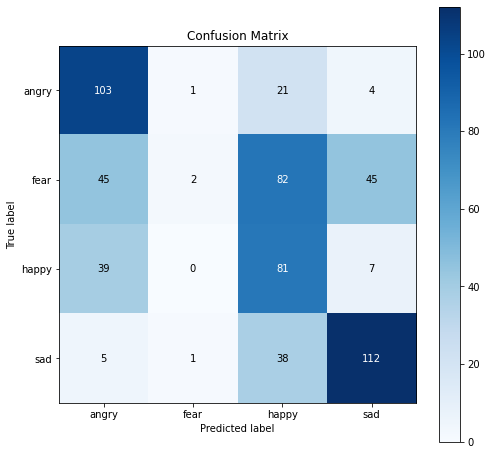

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_13 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4739, 130, 13, 1), (586, 130, 13, 1), (4739, 4), (586, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 13, 64)       640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 130, 13, 64)       256       
_________________________________________________________________
activation_8 (Activation)    (None, 130, 13, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 6, 64)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 65, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 6, 64)         36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 65, 6, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 4s 6ms/step - loss: 2.5731 - categorical_accuracy: 0.2671 - val_loss: 1.3296 - val_categorical_accuracy: 0.3491
Epoch 2/200
297/297 [==============================] - 1s 4ms/step - loss: 1.7609 - categorical_accuracy: 0.3568 - val_loss: 1.1788 - val_categorical_accuracy: 0.4706
Epoch 3/200
297/297 [==============================] - 1s 4ms/step - loss: 1.5340 - categorical_accuracy: 0.4030 - val_loss: 1.1359 - val_categorical_accuracy: 0.5180
Epoch 4/200
297/297 [==============================] - 1s 4ms/step - loss: 1.4233 - categorical_accuracy: 0.4169 - val_loss: 1.1234 - val_categorical_accuracy: 0.5199
Epoch 5/200
297/297 [==============================] - 1s 4ms/step - loss: 1.3621 - categorical_accuracy: 0.4269 - val_loss: 1.1532 - val_categorical_accuracy: 0.4915
Epoch 6/200
297/297 [==============================] - 1s 4ms/step - loss: 1.2934 - categorical_accuracy: 0.4392 - val_loss: 1.1702 - val_categorical_accuracy: 0.457

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc13_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.78      0.73      0.75       129
        fear       0.59      0.27      0.37       174
       happy       0.50      0.75      0.60       127
         sad       0.63      0.79      0.70       156

    accuracy                           0.61       586
   macro avg       0.62      0.63      0.61       586
weighted avg       0.62      0.61      0.59       586



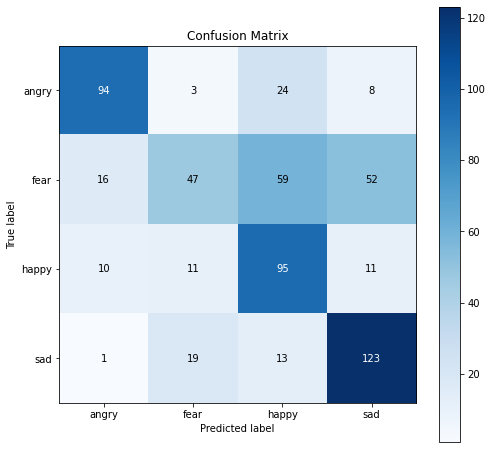

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_26 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=26).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4739, 130, 26, 1), (586, 130, 26, 1), (4739, 4), (586, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 130, 26, 64)       640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 130, 26, 64)       256       
_________________________________________________________________
activation_10 (Activation)   (None, 130, 26, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 13, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 65, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 13, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 65, 13, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 4s 8ms/step - loss: 2.2866 - categorical_accuracy: 0.2982 - val_loss: 1.5806 - val_categorical_accuracy: 0.3510
Epoch 2/200
297/297 [==============================] - 2s 6ms/step - loss: 1.6023 - categorical_accuracy: 0.3720 - val_loss: 1.2002 - val_categorical_accuracy: 0.4497
Epoch 3/200
297/297 [==============================] - 2s 6ms/step - loss: 1.3635 - categorical_accuracy: 0.4243 - val_loss: 1.1283 - val_categorical_accuracy: 0.5180
Epoch 4/200
297/297 [==============================] - 2s 6ms/step - loss: 1.2896 - categorical_accuracy: 0.4403 - val_loss: 1.1099 - val_categorical_accuracy: 0.5332
Epoch 5/200
297/297 [==============================] - 2s 6ms/step - loss: 1.2403 - categorical_accuracy: 0.4477 - val_loss: 1.1166 - val_categorical_accuracy: 0.4934
Epoch 6/200
297/297 [==============================] - 2s 6ms/step - loss: 1.2079 - categorical_accuracy: 0.4691 - val_loss: 1.0900 - val_categorical_accuracy: 0.531

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc26_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.80      0.76      0.78       129
        fear       0.52      0.75      0.62       174
       happy       0.64      0.42      0.50       127
         sad       0.72      0.60      0.65       156

    accuracy                           0.64       586
   macro avg       0.67      0.63      0.64       586
weighted avg       0.66      0.64      0.64       586



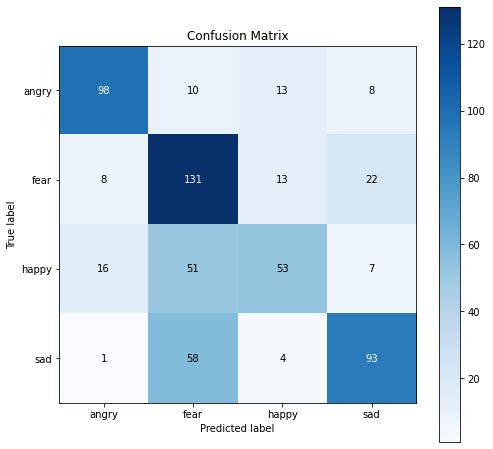

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# mfcc_39 + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 22050
input_length = sampling_rate * audio_duration

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T
    mfcc = np.expand_dims(mfcc, axis=-1)
    features.append(mfcc)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((4739, 130, 39, 1), (586, 130, 39, 1), (4739, 4), (586, 4))

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 130, 39, 64)       640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 130, 39, 64)       256       
_________________________________________________________________
activation_12 (Activation)   (None, 130, 39, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 19, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 65, 19, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 65, 19, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 65, 19, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 4s 10ms/step - loss: 2.2805 - categorical_accuracy: 0.2980 - val_loss: 1.2041 - val_categorical_accuracy: 0.4023
Epoch 2/200
297/297 [==============================] - 2s 7ms/step - loss: 1.5291 - categorical_accuracy: 0.3956 - val_loss: 1.1879 - val_categorical_accuracy: 0.4744
Epoch 3/200
297/297 [==============================] - 2s 7ms/step - loss: 1.3010 - categorical_accuracy: 0.4484 - val_loss: 1.1519 - val_categorical_accuracy: 0.4801
Epoch 4/200
297/297 [==============================] - 2s 7ms/step - loss: 1.2570 - categorical_accuracy: 0.4411 - val_loss: 1.1424 - val_categorical_accuracy: 0.5028
Epoch 5/200
297/297 [==============================] - 2s 7ms/step - loss: 1.1922 - categorical_accuracy: 0.4747 - val_loss: 1.1277 - val_categorical_accuracy: 0.5009
Epoch 6/200
297/297 [==============================] - 2s 7ms/step - loss: 1.1923 - categorical_accuracy: 0.4718 - val_loss: 1.1780 - val_categorical_accuracy: 0.39

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/conv2D_mfcc39_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.78      0.75      0.76       129
        fear       0.49      0.55      0.52       174
       happy       0.43      0.57      0.49       127
         sad       0.76      0.47      0.58       156

    accuracy                           0.58       586
   macro avg       0.61      0.59      0.59       586
weighted avg       0.61      0.58      0.58       586



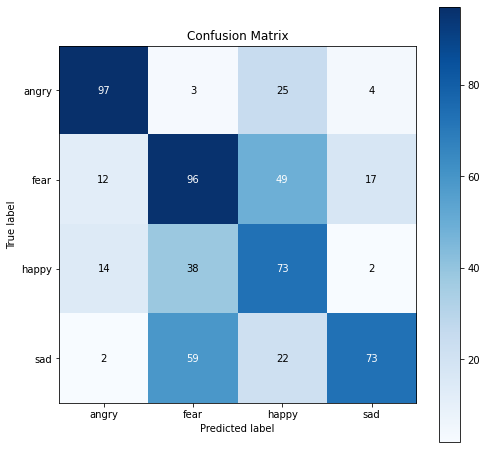

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + basic model

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sample_rate = librosa.load(Ravdess_DF['Paths'][i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.mean(melspec, axis=0)
    features.append(melspec)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])


    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sampling_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.mean(melspec, axis=0)
    features.append(melspec)

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape

(4739, 259)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(259, input_shape=(259, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 259)               67340     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               33280     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 516       
Total params: 117,648
Trainable params: 117,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
75/75 [==============================] - 1s 6ms/step - loss: 1.3408 - accuracy: 0.3890 - val_loss: 1.2058 - val_accuracy: 0.4896
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1191 - accuracy: 0.4973 - val_loss: 1.1691 - val_accuracy: 0.4991
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 1.0412 - accuracy: 0.5388 - val_loss: 1.1411 - val_accuracy: 0.5123
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 1.0091 - accuracy: 0.5478 - val_loss: 1.1507 - val_accuracy: 0.4896
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 0.5488 - val_loss: 1.1528 - val_accuracy: 0.5180
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 0.9664 - accuracy: 0.5873 - val_loss: 1.2313 - val_accuracy: 0.4877
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 0.9672 - accuracy: 0.5773 - val_loss: 1.1462 - val_accuracy: 0.5066
Epoch 8/200
7

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SPEECH_EMOTION_Recognition/Nộp bài(chốt hạ)/model_saver/basic_melspec_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.55      0.62      0.58       129
        fear       0.38      0.40      0.39       174
       happy       0.33      0.36      0.35       127
         sad       0.58      0.43      0.49       156

    accuracy                           0.45       586
   macro avg       0.46      0.45      0.45       586
weighted avg       0.46      0.45      0.45       586



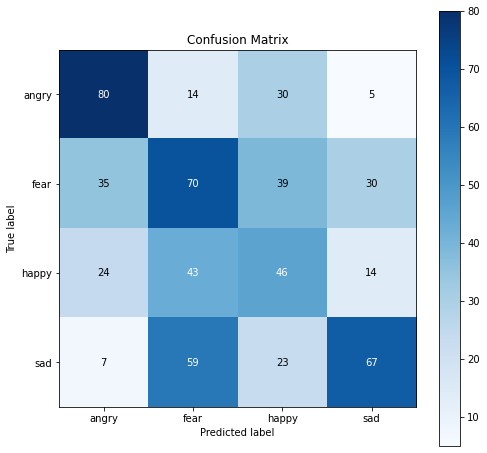

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + conv1D

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sample_rate = librosa.load(Ravdess_DF['Paths'][i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = melspec.reshape(-1,1)
    features.append(melspec)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sampling_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = melspec.reshape(-1,1)
    features.append(melspec)

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4739, 33152, 1), (586, 33152, 1), (4739, 4), (586, 4))

### conv1D

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 33152, 64)         256       
_________________________________________________________________
batch_normalization (BatchNo (None, 33152, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 33152, 64)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8288, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8288, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8288, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8288, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 73s 78ms/step - loss: 1.5096 - categorical_accuracy: 0.2840 - val_loss: 1.6764 - val_categorical_accuracy: 0.2106
Epoch 2/200
297/297 [==============================] - 22s 74ms/step - loss: 1.4265 - categorical_accuracy: 0.3144 - val_loss: 1.2966 - val_categorical_accuracy: 0.3966
Epoch 3/200
297/297 [==============================] - 23s 78ms/step - loss: 1.2529 - categorical_accuracy: 0.4179 - val_loss: 1.2510 - val_categorical_accuracy: 0.3909
Epoch 4/200
297/297 [==============================] - 23s 76ms/step - loss: 1.2056 - categorical_accuracy: 0.4394 - val_loss: 1.1627 - val_categorical_accuracy: 0.4858
Epoch 5/200
297/297 [==============================] - 23s 76ms/step - loss: 1.2520 - categorical_accuracy: 0.4094 - val_loss: 1.2156 - val_categorical_accuracy: 0.3510
Epoch 6/200
297/297 [==============================] - 22s 75ms/step - loss: 1.2317 - categorical_accuracy: 0.3951 - val_loss: 1.2309 - val_categorical_acc

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/speech/dataset/conv1D_melspec_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.89      0.37      0.52       155
        fear       0.31      0.22      0.25       144
       happy       0.35      0.36      0.35       151
         sad       0.47      0.90      0.62       136

    accuracy                           0.45       586
   macro avg       0.50      0.46      0.44       586
weighted avg       0.51      0.45      0.43       586



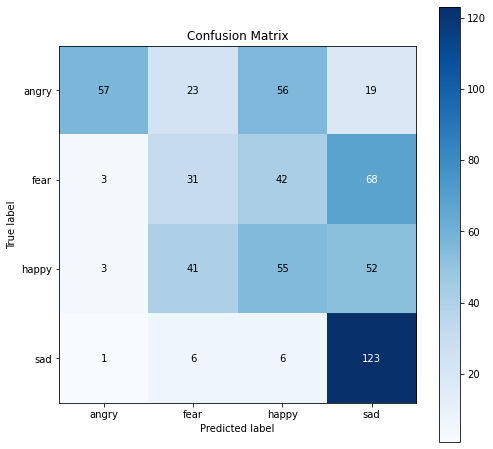

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Mel Spectrogram + conv2D:

In [ ]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sample_rate = librosa.load(Ravdess_DF['Paths'][i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.expand_dims(melspec, axis=-1)

    features.append(melspec)

    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)

for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    if len(signal) > input_length:
      signal = signal[0:input_length]
    elif  input_length > len(signal):
      max_offset = input_length - len(signal)  
      signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sampling_rate, n_mels=128,n_fft=2048,hop_length=512)   
    melspec = np.expand_dims(melspec, axis=-1)

    features.append(melspec)

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4739, 128, 259, 1), (586, 128, 259, 1), (4739, 4), (586, 4))

### conv2D

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 259, 64)      640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 259, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 128, 259, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 129, 64)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 129, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 129, 64)       36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 129, 64)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 13s 34ms/step - loss: 2.9656 - categorical_accuracy: 0.3467 - val_loss: 1.3048 - val_categorical_accuracy: 0.4516
Epoch 2/200
297/297 [==============================] - 9s 31ms/step - loss: 1.8039 - categorical_accuracy: 0.4321 - val_loss: 1.2648 - val_categorical_accuracy: 0.4725
Epoch 3/200
297/297 [==============================] - 9s 31ms/step - loss: 1.4471 - categorical_accuracy: 0.4557 - val_loss: 1.2379 - val_categorical_accuracy: 0.4516
Epoch 4/200
297/297 [==============================] - 9s 31ms/step - loss: 1.3927 - categorical_accuracy: 0.4504 - val_loss: 1.2342 - val_categorical_accuracy: 0.4383
Epoch 5/200
297/297 [==============================] - 9s 31ms/step - loss: 1.3831 - categorical_accuracy: 0.4378 - val_loss: 1.2635 - val_categorical_accuracy: 0.4175
Epoch 6/200
297/297 [==============================] - 9s 31ms/step - loss: 1.3166 - categorical_accuracy: 0.4630 - val_loss: 1.2553 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/speech/dataset/conv2D_melspec_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.76      0.43      0.55       155
        fear       0.44      0.33      0.38       144
       happy       0.44      0.38      0.41       151
         sad       0.47      0.90      0.62       136

    accuracy                           0.50       586
   macro avg       0.53      0.51      0.49       586
weighted avg       0.53      0.50      0.48       586



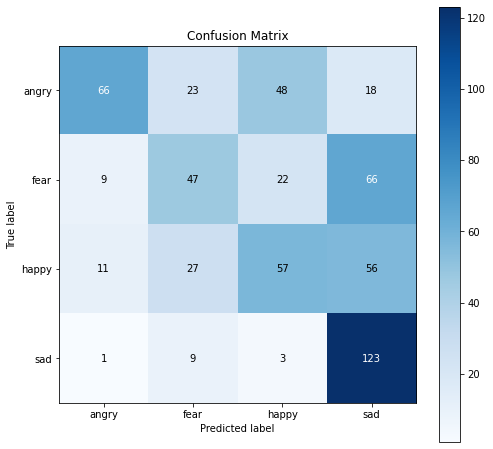

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + basic model

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    tempogram = np.mean(librosa.feature.tempogram(signal, sr).T, axis=0)
    features.append(tempogram)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])

    tempogram = np.mean(librosa.feature.tempogram(signal, sr).T, axis=0)
    features.append(tempogram)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(384, input_shape=(384, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 384)               147840    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               49280     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 214,148
Trainable params: 214,148
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
75/75 [==============================] - 14s 8ms/step - loss: 1.3353 - accuracy: 0.3311 - val_loss: 1.2254 - val_accuracy: 0.4535
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 1.2242 - accuracy: 0.4299 - val_loss: 1.1903 - val_accuracy: 0.4364
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1709 - accuracy: 0.4505 - val_loss: 1.0957 - val_accuracy: 0.5028
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1565 - accuracy: 0.4644 - val_loss: 1.0961 - val_accuracy: 0.5028
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1679 - accuracy: 0.4572 - val_loss: 1.1719 - val_accuracy: 0.4668
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1635 - accuracy: 0.4635 - val_loss: 1.0529 - val_accuracy: 0.5123
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 1.1196 - accuracy: 0.4817 - val_loss: 1.0687 - val_accuracy: 0.5332
Epoch 8/200


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/speech/dataset/basic_tempogram_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.67      0.61      0.64       155
        fear       0.41      0.27      0.33       144
       happy       0.49      0.56      0.52       151
         sad       0.54      0.70      0.61       136

    accuracy                           0.54       586
   macro avg       0.53      0.54      0.53       586
weighted avg       0.53      0.54      0.53       586



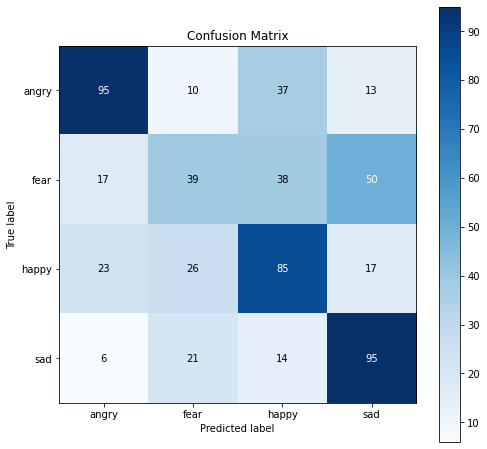

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + conv1D

In [ ]:
audio_duration = 2
sampling_rate = 44100
input_length = sampling_rate * audio_duration


In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    features.append(tempogram)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    features.append(tempogram)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4739, 384, 173), (586, 384, 173), (4739, 4), (586, 4))

### conv1D

In [ ]:

# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256

In [ ]:
model = Sequential(name='Audio_CNN_1D')

# LFLB1
model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.5))

# LFLB2
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB3
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LFLB4
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling1D(pool_size=4, strides=4))
model.add(Dropout(0.25))

# LSTM
model.add(LSTM(units=num_lstm))

# FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt= keras.optimizers.Adam(lr=0.01, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "Audio_CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 384, 64)           33280     
_________________________________________________________________
batch_normalization (BatchNo (None, 384, 64)           256       
_________________________________________________________________
activation (Activation)      (None, 384, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 64)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Audio_1DCNN.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 55s 15ms/step - loss: 1.3757 - categorical_accuracy: 0.3172 - val_loss: 1.2310 - val_categorical_accuracy: 0.4288
Epoch 2/200
297/297 [==============================] - 3s 10ms/step - loss: 1.2784 - categorical_accuracy: 0.3888 - val_loss: 1.1686 - val_categorical_accuracy: 0.4421
Epoch 3/200
297/297 [==============================] - 3s 10ms/step - loss: 1.2690 - categorical_accuracy: 0.3897 - val_loss: 1.3972 - val_categorical_accuracy: 0.2827
Epoch 4/200
297/297 [==============================] - 3s 10ms/step - loss: 1.2441 - categorical_accuracy: 0.4150 - val_loss: 1.2183 - val_categorical_accuracy: 0.3852
Epoch 5/200
297/297 [==============================] - 3s 11ms/step - loss: 1.2282 - categorical_accuracy: 0.4291 - val_loss: 1.5317 - val_categorical_accuracy: 0.2922
Epoch 6/200
297/297 [==============================] - 3s 10ms/step - loss: 1.2426 - categorical_accuracy: 0.4095 - val_loss: 1.3484 - val_categorical_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/speech/dataset/conv1D_tempogram_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.35      0.97      0.52       155
        fear       0.35      0.18      0.24       144
       happy       0.41      0.11      0.17       151
         sad       0.70      0.24      0.35       136

    accuracy                           0.38       586
   macro avg       0.45      0.37      0.32       586
weighted avg       0.45      0.38      0.32       586



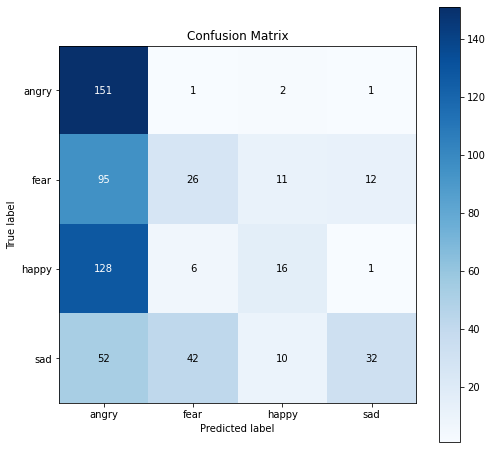

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Tempogram + conv2D

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    tempogram = np.expand_dims(tempogram, axis=-1)
    features.append(tempogram)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)


for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    tempogram = librosa.feature.tempogram(signal, sr)
    tempogram = np.expand_dims(tempogram, axis=-1)
    features.append(tempogram)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4739, 384, 173, 1), (586, 384, 173, 1), (4739, 4), (586, 4))

### conv2D

In [ ]:
# CNN I/P Config
num_classes = 4
input_shape = X_train.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

In [ ]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 384, 173, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 384, 173, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 384, 173, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 86, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 192, 86, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 86, 64)       36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 86, 64)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train Config

batch_size = 16
num_epochs = 200

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(X_val, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/200
297/297 [==============================] - 65s 65ms/step - loss: 5.0002 - categorical_accuracy: 0.3232 - val_loss: 2.3896 - val_categorical_accuracy: 0.2581
Epoch 2/200
297/297 [==============================] - 18s 61ms/step - loss: 1.9740 - categorical_accuracy: 0.3631 - val_loss: 1.3024 - val_categorical_accuracy: 0.4383
Epoch 3/200
297/297 [==============================] - 18s 61ms/step - loss: 1.7586 - categorical_accuracy: 0.3837 - val_loss: 3.2090 - val_categorical_accuracy: 0.2751
Epoch 4/200
297/297 [==============================] - 18s 61ms/step - loss: 1.7016 - categorical_accuracy: 0.3922 - val_loss: 1.2770 - val_categorical_accuracy: 0.4573
Epoch 5/200
297/297 [==============================] - 18s 61ms/step - loss: 1.5908 - categorical_accuracy: 0.3975 - val_loss: 2.1401 - val_categorical_accuracy: 0.2372
Epoch 6/200
297/297 [==============================] - 18s 61ms/step - loss: 1.5694 - categorical_accuracy: 0.3934 - val_loss: 1.6726 - val_categorical_acc

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/speech/dataset/conv2D_tempogram_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.62      0.49      0.55       155
        fear       0.44      0.46      0.45       144
       happy       0.37      0.57      0.45       151
         sad       0.64      0.40      0.49       136

    accuracy                           0.48       586
   macro avg       0.52      0.48      0.49       586
weighted avg       0.52      0.48      0.49       586



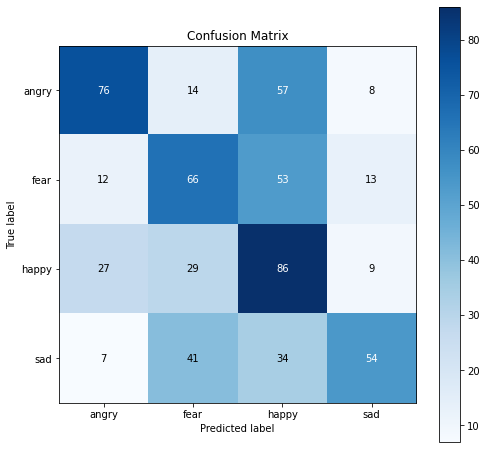

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))

# Combined feature + basic model

In [ ]:
features = []
labels = []
for i in range(len(Ravdess_DF['Paths'])):
  if ((Ravdess_DF['Emotion'][i] == '03') | (Ravdess_DF['Emotion'][i] == '04') | 
      (Ravdess_DF['Emotion'][i] == '05') | (Ravdess_DF['Emotion'][i] == '06')):
    signal, sr = librosa.load(Ravdess_DF['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0)
    mel_spec = np.mean(librosa.feature.melspectrogram(signal, sr, n_mels=28).T, axis=0)
    tempogram = np.mean(librosa.feature.tempogram(signal, sr, win_length=24).T, axis=0)

    mfcc = pd.DataFrame(mfcc)
    mel_spec = pd.DataFrame(mel_spec)
    tempogram = pd.DataFrame(tempogram)
    feature = mfcc.append(mel_spec).append(tempogram)
    feature = np.array(feature[0])
    features.append(feature)
    if Ravdess_DF['Emotion'][i] == '03':
      labels.append(0)
    elif Ravdess_DF['Emotion'][i] == '04':
      labels.append(1)
    elif Ravdess_DF['Emotion'][i] == '05':
      labels.append(2)
    elif Ravdess_DF['Emotion'][i] == '06':
      labels.append(3)



for i in range(len(CREMA_D_df)):
  if ((CREMA_D_df['Emotion'][i] == 'HAP') | (CREMA_D_df['Emotion'][i] == 'SAD') | 
      (CREMA_D_df['Emotion'][i] == 'ANG') | (CREMA_D_df['Emotion'][i] == 'FEA')):
    
    if CREMA_D_df['Emotion'][i] == 'HAP':
      labels.append(0)
    elif CREMA_D_df['Emotion'][i] == 'SAD':
      labels.append(1)
    elif CREMA_D_df['Emotion'][i] == 'ANG':
      labels.append(2)
    elif CREMA_D_df['Emotion'][i] == 'FEA':
      labels.append(3)


    signal, sr =  librosa.load(CREMA_D_df['Paths'][i])
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=39).T,axis=0)
    mel_spec = np.mean(librosa.feature.melspectrogram(signal, sr, n_mels=28).T, axis=0)
    tempogram = np.mean(librosa.feature.tempogram(signal, sr, win_length=24).T, axis=0)

    mfcc = pd.DataFrame(mfcc)
    mel_spec = pd.DataFrame(mel_spec)
    tempogram = pd.DataFrame(tempogram)
    feature = mfcc.append(mel_spec).append(tempogram)
    feature = np.array(feature[0])
    features.append(feature)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
features = sc.fit_transform(features)

In [ ]:
X = features
y = labels

y = np.array(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [ ]:
X_train.shape

(4739, 91)

## basic models:

In [ ]:
model = Sequential()
model.add(Dense(91, input_shape=(91, ), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 91)                8372      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               11776     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 37,176
Trainable params: 37,176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_val, y_val))

Epoch 1/200
75/75 [==============================] - 1s 6ms/step - loss: 1.1968 - accuracy: 0.4508 - val_loss: 0.9375 - val_accuracy: 0.6015
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 0.9391 - accuracy: 0.5872 - val_loss: 0.8403 - val_accuracy: 0.6319
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 0.8514 - accuracy: 0.6350 - val_loss: 0.8108 - val_accuracy: 0.6509
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 0.8285 - accuracy: 0.6517 - val_loss: 0.8297 - val_accuracy: 0.6319
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 0.7633 - accuracy: 0.6788 - val_loss: 0.7867 - val_accuracy: 0.6584
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.6955 - val_loss: 0.8593 - val_accuracy: 0.6186
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 0.7223 - accuracy: 0.6914 - val_loss: 0.7707 - val_accuracy: 0.6641
Epoch 8/200
7

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/speech/dataset/basic_combined_merged.h5')

###test_result

In [ ]:
d = {0: 'happy',
     1: 'sad',
     2: 'angry',
     3: 'fear'}
Y_test_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_pred = list(map(lambda x: d[x], Y_test_pred))
y_test = np.argmax(y_test, axis=-1)
y_test = list(map(lambda x: d[x], y_test))
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

       angry       0.70      0.64      0.67       155
        fear       0.53      0.46      0.49       144
       happy       0.54      0.59      0.56       151
         sad       0.64      0.72      0.68       136

    accuracy                           0.60       586
   macro avg       0.60      0.60      0.60       586
weighted avg       0.60      0.60      0.60       586



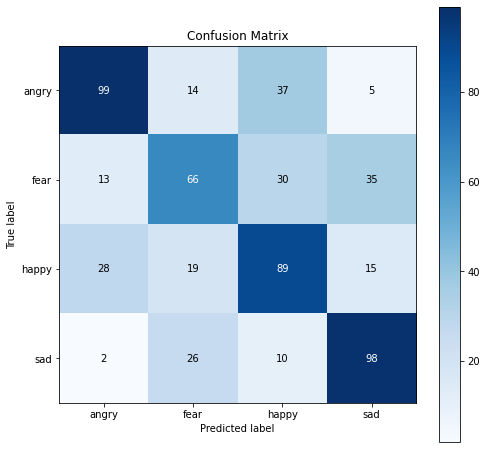

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    Y_test_pred,
    figsize=(8,8))